In [14]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn as nn  # to load all neural net functionality
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt

### Loading Data

In [15]:
training_data = datasets.mnist.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.mnist.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

In [16]:
training_data, validation_data = torch.utils.data.random_split(training_data, [50000, 10000])

In [17]:
print(len(training_data), len(validation_data), len(test_data))

50000 10000 10000


### CNN Baseline Model
Model with two CNN layers (including max pooling), one dense and an output classification layer, with suitable number of filters and units, respectively.

In [41]:
import torch.nn as nn

num_classes = 10


def cnn_model(num_classes=10):
    class CNNModel(nn.Module):
        def __init__(self, num_classes):
            super(CNNModel, self).__init__()
            # First CNN layer
            self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
            self.relu1 = nn.ReLU()
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

            # Second CNN layer
            self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
            self.relu2 = nn.ReLU()
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

            # Dense layer
            self.fc1 = nn.Linear(32 * 7 * 7, 128)  # Assuming input image size is 28x28 after pooling
            self.relu3 = nn.ReLU()

            # Output layer
            self.fc2 = nn.Linear(128, num_classes)

        def forward(self, x):
            # Convolutional layers
            x = self.pool1(self.relu1(self.conv1(x)))
            x = self.pool2(self.relu2(self.conv2(x)))

            # Flatten
            x = x.view(-1, 32 * 7 * 7)  # Reshape for the fully connected layer

            # Dense layer
            x = self.relu3(self.fc1(x))

            # Output layer
            x = self.fc2(x)
            return x

    return CNNModel(num_classes)


model_description = "Conv filters=16, kernel=3, s=1, p=1 -> ReLU -> Conv filters=32, kernels=3, s=1, p=1 -> ReLU -> MaxPool k=2, s=2 -> Dense 128 -> ReLU -> Output 10"

In [42]:
model = cnn_model()
from torchsummary import summary

summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           4,640
              ReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
            Linear-7                  [-1, 128]         200,832
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 10]           1,290
Total params: 206,922
Trainable params: 206,922
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.33
Params size (MB): 0.79
Estimated Total Size (MB): 1.12
-------------------------------------------

In [47]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


class Result:
    def __init__(self, network, epoch: int, batch_size: int, train_accuracy: [float], val_accuracy: [float],
                 train_loss: [float], val_loss: [float], cm: any):
        self.network = network,
        self.epoch = epoch,
        self.batch_size = batch_size
        self.train_loss = train_loss
        self.val_loss = val_loss
        self.train_accuracy = train_accuracy
        self.val_accuracy = val_accuracy
        self.cm = cm

    def __str__(self):
        return f'Network: {self.network}, Epochs: {self.epoch}, Batch size: {self.batch_size}, Final accuracy: [train:{self.train_accuracy[-1]}, val:{self.val_accuracy[-1]}] Final loss: [train:{self.train_loss[-1]}, val:{self.val_loss[-1]}'

    def title(self):
        return f'Network: {self.network}, Epochs: {self.epoch}, Batch: {self.batch_size}'

    def plot(self, plot_cm):
        f = plt.figure(figsize=(12, 4))
        ax1 = f.add_subplot(121)
        ax2 = f.add_subplot(122)
        ax1.plot(self.train_loss, label='Training loss')
        ax1.plot(self.val_loss, label='Validation loss')
        ax1.legend()
        ax1.grid()
        ax2.plot(self.train_accuracy, label='Training acc')
        ax2.plot(self.val_accuracy, label='Validation acc')
        ax2.legend()
        ax2.grid()
        if plot_cm:
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            disp.plot(colorbar=False, cmap='Blues')
        plt.show()

    def plot_result(self, cm=False):
        print(self.title())
        print(f"Final val accuracy: {self.val_accuracy[-1]}")
        self.plot(cm)
        print("--------------------------------------------")

    def print_results(self):
        print("--------------------------------------------")
        print(self.title())
        print(f"Train accuracy: {self.train_accuracy[-1]}")
        print(f"Validation accuracy: {self.val_accuracy[-1]}")


results: [Result] = []

### Training

Implement the training / evaluation loop
Remember training / validation cost and accuracy per epoch and return them as list.

In [63]:
def train_eval(model, optimizer, nepochs, training_loader, test_loader, scheduler=None, verbose=False):
    """
    Perform training and evaluation loop.
    :param model: Model to be trained
    :param optimizer: Optimiser to use for training
    :param nepochs: Number of epochs
    :param training_loader: Loader to provide mini-batches of training samples
    :param test_loader: Loader to provide mini-batches of validation samples
    :param scheduler: Scheduler used for a learning rate schedule
    :return: Lists with training and validation cost and accuracy per epoch.
    """
    cost_hist = []
    cost_hist_val = []
    acc_hist = []
    acc_hist_val = []

    cost_ce = torch.nn.CrossEntropyLoss()

    for epoch in range(nepochs):
        acc, cost = 0, 0
        acc_val, cost_val = 0, 0
        batch_count = 0

        for batch_idx, (train_x, train_y) in enumerate(training_loader):
            optimizer.zero_grad()
            yhat = model(train_x)
            loss = cost_ce(yhat, train_y)
            loss.backward()
            optimizer.step()

            acc += (yhat.argmax(1) == train_y).float().mean()
            cost += loss.item()
            batch_count += 1
            
        with torch.no_grad():
            for batch_idx, (val_x, val_y) in enumerate(validation_loader):
                yhat_val = model(val_x)
                loss_val = cost_ce(yhat_val, val_y)
                acc_val += (yhat_val.argmax(1) == val_y).float().mean()
                cost_val += loss_val.item()

        cost_hist.append(cost / batch_count)
        acc_hist.append(acc / batch_count)
        cost_hist_val.append(cost_val / batch_count)
        acc_hist_val.append(acc_val / batch_count)

        if verbose:
            print(f"Epoch {epoch + 1}")
            print(f"Train:      Accuracy={acc_hist[-1]:.4f}, Cost: {cost_hist[-1]:.4f}")
            print(f"Validation: Accuracy={acc_hist_val[-1]:.4f}, Cost: {cost_hist_val[-1]:.4f}")
            print("------------------------------------------")
    if not verbose:
        print(f"Final Validation Accuracy={acc_hist_val[-1]:.4f} Cost: {cost_hist_val[-1]:.4f}")
        print(f"Final Training   Accuracy={acc_hist[-1]:.4f} Cost: {cost_hist[-1]:.4f}")

    return cost_hist, cost_hist_val, acc_hist, acc_hist_val

### Train Baseline CNN Model

Follow the "Steps to Test and Tune a Model" as presented in the lecture.

Train the baseline with SGD without momentum and fixed learning rate. Tune the learning rate by this procedure.

Determine a suitable number of epochs.

Epoch 1
Train:      Accuracy=0.8499, Cost: 0.4142
Validation: Accuracy=0.1719, Cost: 0.0823
------------------------------------------
Epoch 2
Train:      Accuracy=0.8549, Cost: 0.3977
Validation: Accuracy=0.1663, Cost: 0.0918
------------------------------------------
Epoch 3
Train:      Accuracy=0.8601, Cost: 0.3853
Validation: Accuracy=0.1723, Cost: 0.0776
------------------------------------------
Epoch 4
Train:      Accuracy=0.8642, Cost: 0.3746
Validation: Accuracy=0.1713, Cost: 0.0820
------------------------------------------
Epoch 5
Train:      Accuracy=0.8684, Cost: 0.3631
Validation: Accuracy=0.1751, Cost: 0.0718
------------------------------------------
--------------------------------------------
Network: ('Conv filters=16, kernel=3, s=1, p=1 -> ReLU -> Conv filters=32, kernels=3, s=1, p=1 -> ReLU -> MaxPool k=2, s=2 -> Dense 128 -> ReLU -> Output 10',), Epochs: (5,), Batch: 64
Final val accuracy: 0.17507192492485046


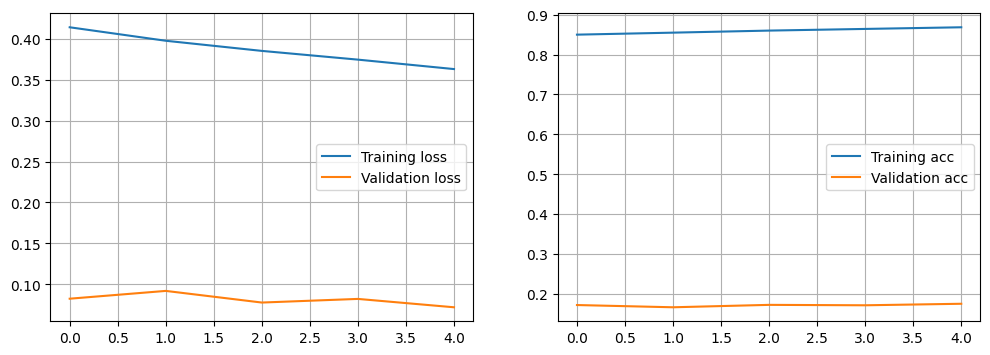

In [64]:
n_epochs = 5
batch_size = 64
lr = 0.01

optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0)
training_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)

cost_hist, cost_hist_test, acc_hist, acc_hist_test = train_eval(model, optimizer, n_epochs, training_loader,
                                                                validation_loader, verbose=True)
results.append(
    Result(model_description, n_epochs, batch_size, acc_hist, acc_hist_test, cost_hist, cost_hist_test, None))
results[-1].plot_result()

### Cross-Validation

Use 5-fold cross validation to estimate the accuracy and an error bar of the accuracy estimate.


In [ ]:
cross_validation_results = []
k_fold = 5

for i in range(k_fold):
    



### Analyse Different Optimisers with different Settings 

Use the code above to explore different settings for the different optimizers. Use batchsize 64.

1. *SGD*: Refer to the results from above - for later comparison.
<br>

2. *Momentum*: Play with at least three different settings when using momentum: learning rate, momentum parameter, Nesterov flag. Start with momentum=0.9 without Nesterov and suitable learning rate, then vary the momentum parameter and independently the learning rate. Can you see an impact of using Nesterov? What is your recommended best choice (lr, momentum, nesterov, nepochs) for the given problem?
<br>

3. *RMSProp*: Same thing now for RMSprop (without momentum). Play with at least three different settings when using RMSprop: lr, alpha. Start with the default settings of pytorch with (lr=0.01, alpha=0.99,centered=False). Then vary alpha and independently the learning rate. Can you see an impact when using centered=True? What is your recommended best choice (learning rate, alpha, centered, nepochs) for the given problem?<br>
<br>

4. *Adam*: Same thing now for Adam. Play with at least three different settings. Start with the default settings of pytorch. What is your recommended best choice for the given problem?<br>
<br>


In [ ]:
nbatch = 64
nepochs =

training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=nbatch, shuffle=True)

model = mlp()
optimizer = ...
cost_hist, cost_hist_test, acc_hist, acc_hist_test = train_eval(model, optimizer, nepochs, training_loader,
                                                                validation_loader)


### Plots and Comments (for the different steps described above) 

### Learning Rate Schedule

Modify your `train_eval` method implemented above to support using a learning rate schedule for SGD (without momentum) - by using e.g. StepLR. What are your preferred settings for the given task?

Compare and evaluate the training performance with the results obtained for the different optimizers above and provide a judgement.